*Note: This notebook contains raw exploratory data analysis (EDA), feature selection experiments (e.g., PCA), and the evaluation of various clustering algorithms (GMM, Agglomerative). For the final, streamlined code and business insights, please refer to 01_customer_segmentation_and_prediction.ipynb.*

# Step 1: Enviroment Setup and Dataset Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix, accuracy_score, precision_score, f1_score, recall_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# Dataset Loading
df = pd.read_csv('marketing_campaign.csv', sep='\t')

# Step 2: Dataset Structure

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [3]:
df.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


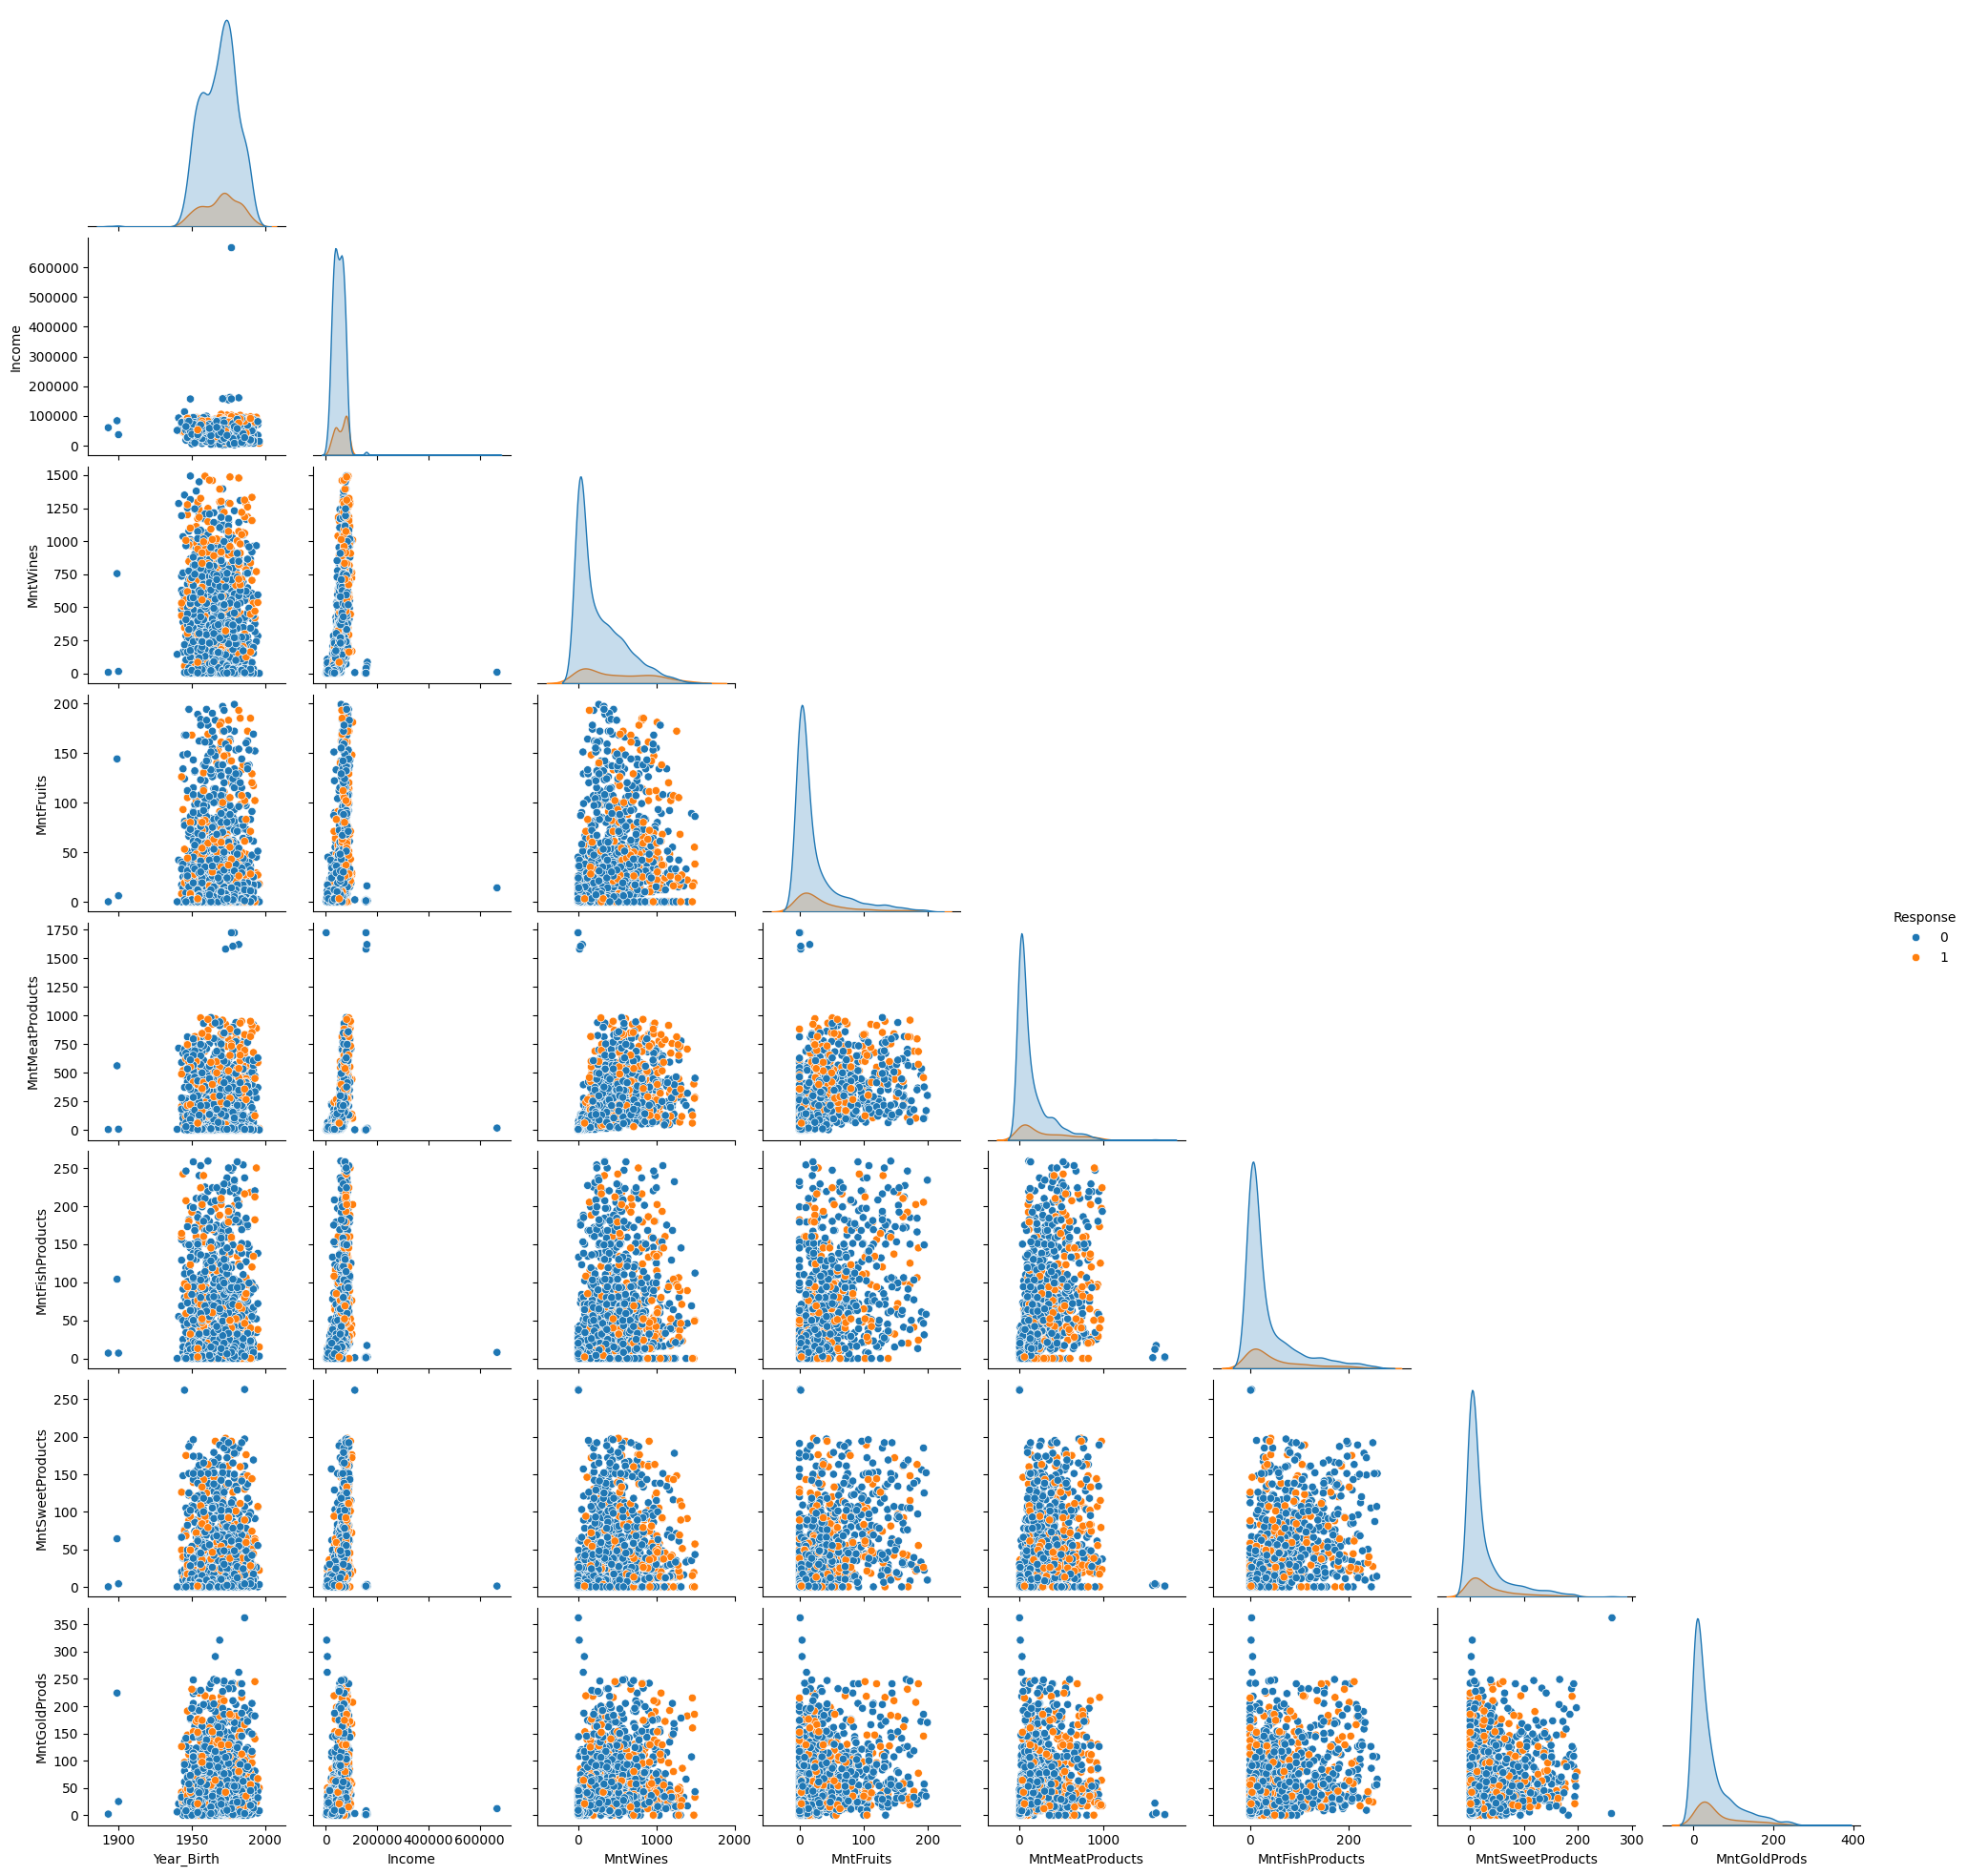

In [4]:
sns.pairplot(df, vars=['Year_Birth','Income','MntWines','MntFruits','MntMeatProducts','MntFishProducts', 'MntSweetProducts','MntGoldProds'], hue='Response' ,corner=True);

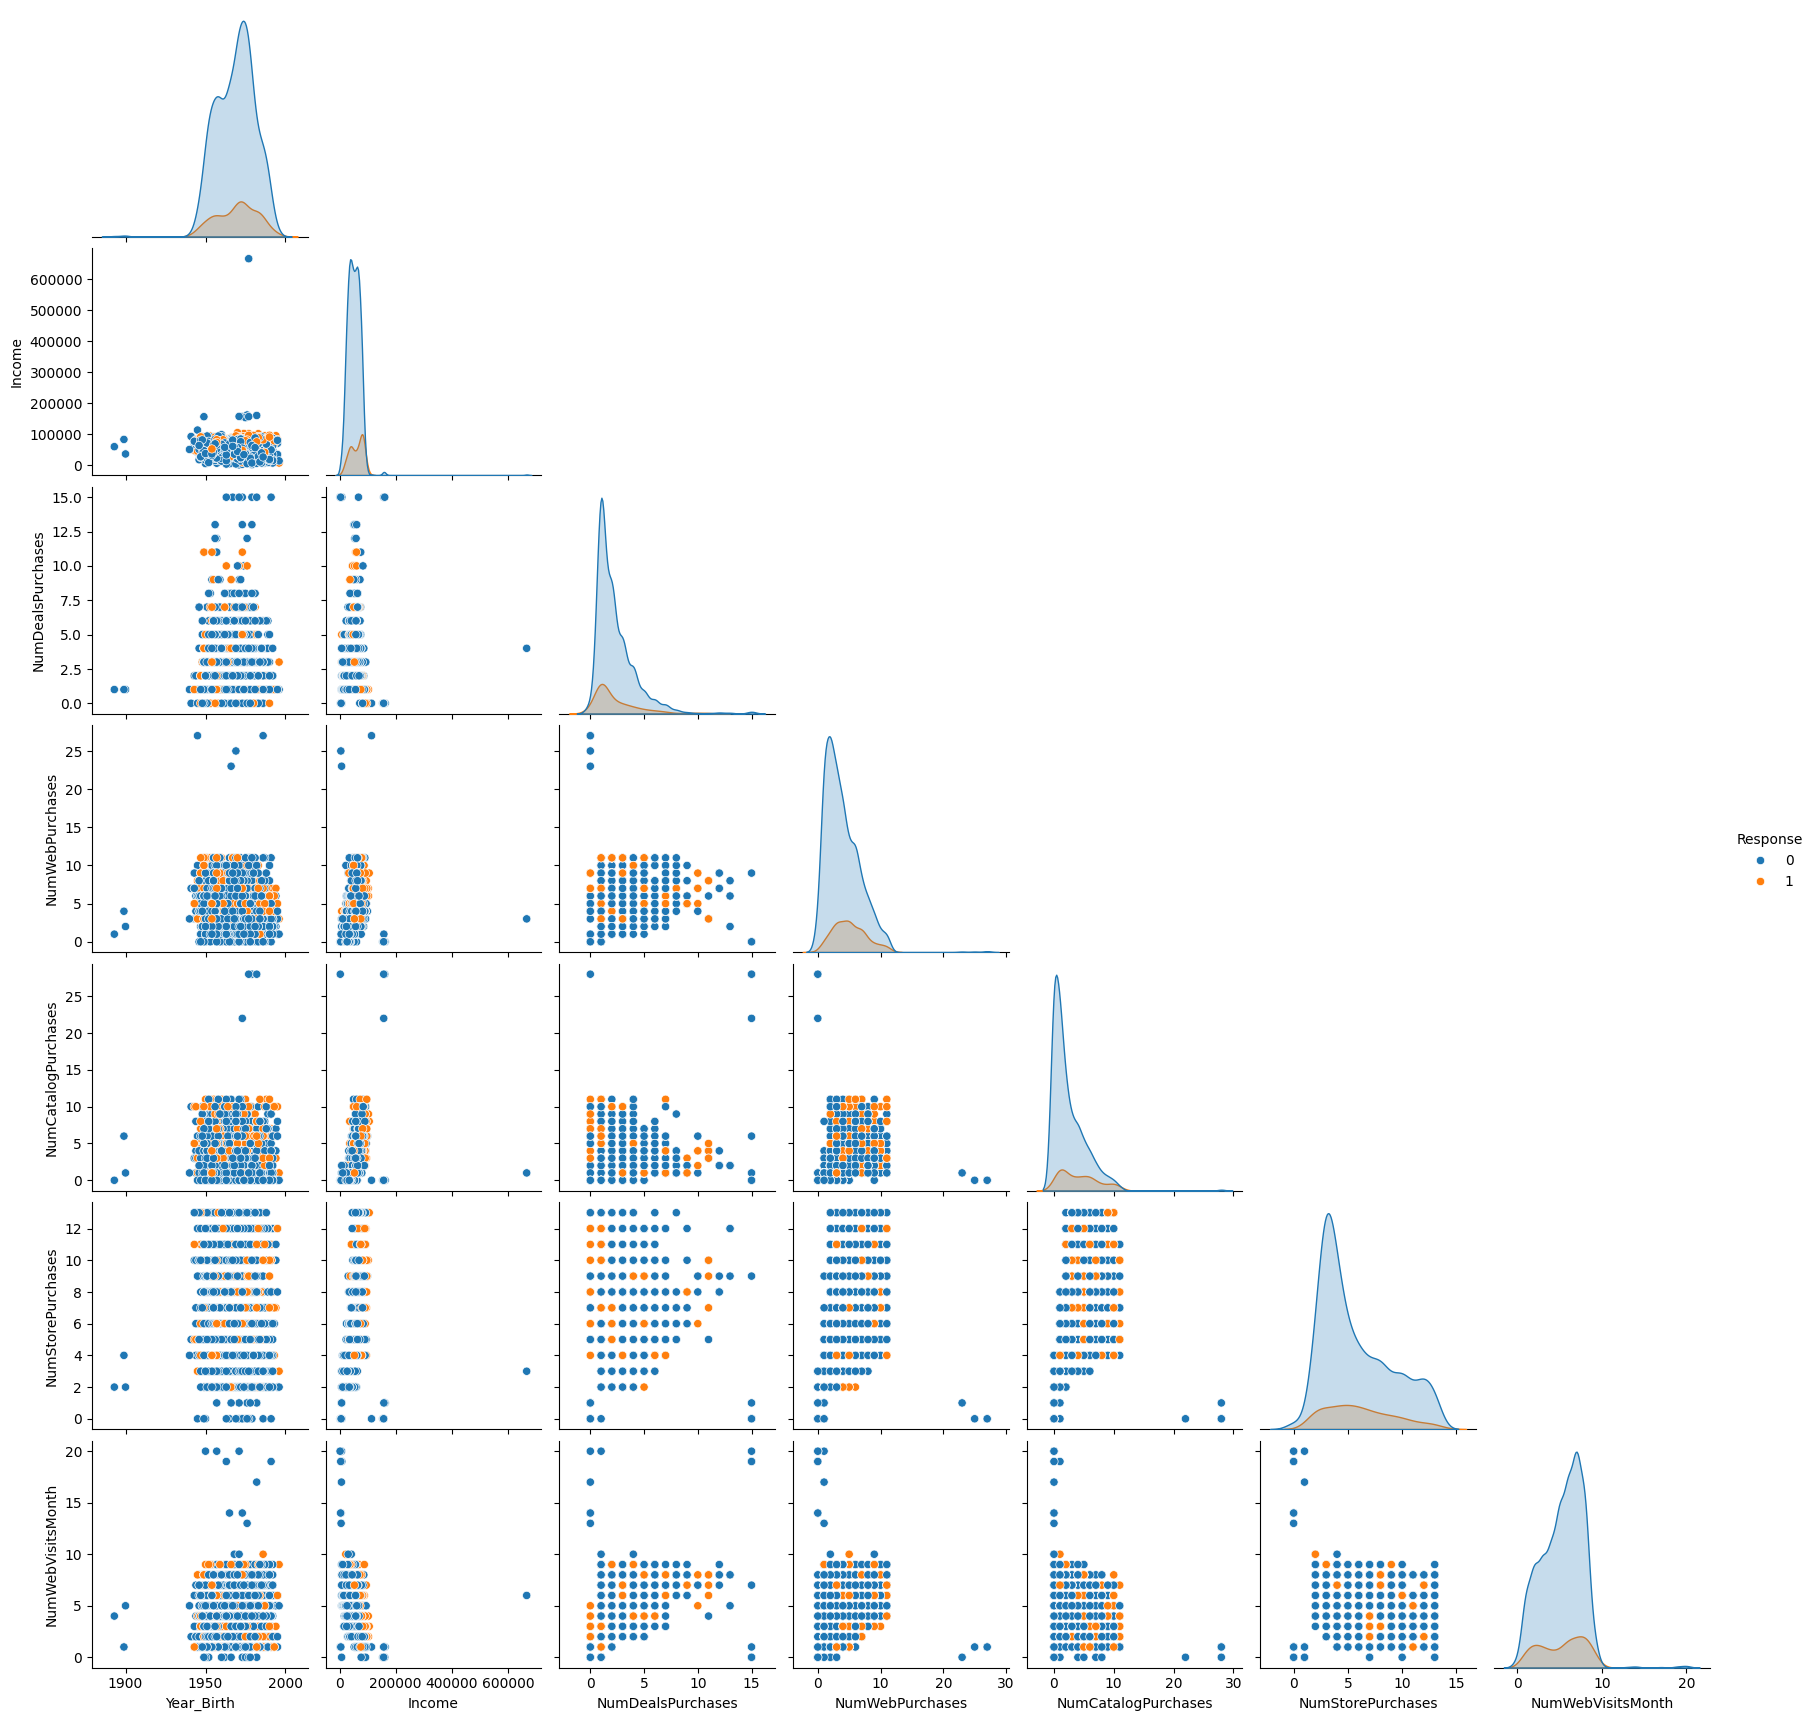

In [5]:
sns.pairplot(df, vars=['Year_Birth','Income','NumDealsPurchases','NumWebPurchases','NumCatalogPurchases','NumStorePurchases', 'NumWebVisitsMonth'], hue='Response' ,corner=True);

# Step 3: Dataset Prepering

In [6]:
# Replacing missing values in Income
df['Income'] = df['Income'].fillna(df.groupby('Education')['Income'].transform('mean'))

In [7]:
# Removing outliers
df = df[df['Year_Birth'] > 1940]
df = df[df['Income'] < 400000]

In [8]:
# Family and household income per capita
df['Kids'] = df['Kidhome'] + df['Teenhome'] 
df['Partner'] = df['Marital_Status'].isin(['Together','Married']).astype(int)
df['Household'] = df['Kids'] + df['Partner'] + 1 
df['IncomePerCapita'] = df['Income'] / df['Household']

# Client tenure
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
latest_date = df['Dt_Customer'].max()
df['Tenure_Months'] = (latest_date.year - df['Dt_Customer'].dt.year) * 12 + (latest_date.month - df['Dt_Customer'].dt.month)

# Amount spent on all products
df['MntAllProducts'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

# Client age 
df['Age'] = 2014 - df['Year_Birth']

# How many campaigns accepted
df['AcceptedCmp'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5'] + df['Response']

In [9]:
# Average income per education level
df.groupby('Education')['Income'].agg(['mean','median','count']).round().sort_values(by='mean', ascending=False)

,mean,median,count
Education,,,
PhD,56099.0,55336.0,484
Master,52918.0,51044.0,370
Graduation,52175.0,52472.0,1126
2n Cycle,47625.0,46891.0,201
Basic,20306.0,20744.0,54


In [10]:
# Income correlation
education_map = {
'Basic': 1,
'2n Cycle': 2,
'Graduation': 3,
'Master': 4,
'PhD': 5
}
df['Education_Numeric'] = df['Education'].map(education_map)

income_corr = df.corr(numeric_only=True)['Education_Numeric'].sort_values(ascending=False)
income_corr

Education_Numeric      1.000000
MntWines               0.212816
Age                    0.192426
Income                 0.180000
Teenhome               0.136270
MntAllProducts         0.105695
Response               0.099111
NumWebPurchases        0.098398
NumStorePurchases      0.092124
IncomePerCapita        0.085838
NumCatalogPurchases    0.085392
AcceptedCmp            0.069373
Kids                   0.061203
AcceptedCmp4           0.057863
Household              0.045879
MntMeatProducts        0.042288
NumDealsPurchases      0.036899
AcceptedCmp5           0.033396
AcceptedCmp2           0.023983
AcceptedCmp3           0.003352
ID                    -0.000480
AcceptedCmp1          -0.004175
Partner               -0.009229
Recency               -0.015243
Complain              -0.038874
Kidhome               -0.052340
NumWebVisitsMonth     -0.054631
Tenure_Months         -0.063670
MntFruits             -0.077591
MntSweetProducts      -0.094744
MntGoldProds          -0.096312
MntFishP

In [11]:
# Removing unnecessary variables
df = df.drop(['ID','Year_Birth','Education','Marital_Status','Kidhome','Teenhome','Dt_Customer','Z_CostContact','Z_Revenue'], axis=1)
df = df.reset_index(drop=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2235 entries, 0 to 2234
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Income               2235 non-null   float64
 1   Recency              2235 non-null   int64  
 2   MntWines             2235 non-null   int64  
 3   MntFruits            2235 non-null   int64  
 4   MntMeatProducts      2235 non-null   int64  
 5   MntFishProducts      2235 non-null   int64  
 6   MntSweetProducts     2235 non-null   int64  
 7   MntGoldProds         2235 non-null   int64  
 8   NumDealsPurchases    2235 non-null   int64  
 9   NumWebPurchases      2235 non-null   int64  
 10  NumCatalogPurchases  2235 non-null   int64  
 11  NumStorePurchases    2235 non-null   int64  
 12  NumWebVisitsMonth    2235 non-null   int64  
 13  AcceptedCmp3         2235 non-null   int64  
 14  AcceptedCmp4         2235 non-null   int64  
 15  AcceptedCmp5         2235 non-null   i

In [13]:
# Dataset scaling
scaler = StandardScaler()
df_scaled_numpy = scaler.fit_transform(df) 
df_scaled = pd.DataFrame(df_scaled_numpy, columns=df.columns)



# Step 4: Principal Component Analysis (PCA)*
*Not used in further analysis to have more explainability

In [14]:
# Finiding optimal number of components
for k in range(3,10):
    pca = PCA(n_components=k)
    pca_data = pca.fit(df_scaled)
    var = pca_data.explained_variance_ratio_.sum() 
    print(f"Number of components: {k}, Variance: {var:.2%}")

Number of components: 3, Variance: 46.85%
Number of components: 4, Variance: 52.49%
Number of components: 5, Variance: 57.42%
Number of components: 6, Variance: 61.56%
Number of components: 7, Variance: 65.06%
Number of components: 8, Variance: 68.52%
Number of components: 9, Variance: 71.73%


In [15]:
# PCA with 7 components
n = 6
pca = PCA(n_components=n)
pca_data = pca.fit_transform(df_scaled)
pca_cols = [f'PC{i+1}' for i in range(n)]
pca_df = pd.DataFrame(data=pca_data, columns=pca_cols)

# Step 5: Feature Selection

In [16]:
feats_for_clustering = [
'IncomePerCapita', 'Kids', 'Partner', 'Age', 'Education_Numeric', 'Complain', #demo
'Tenure_Months', 'Recency', #time
'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', #spent
'NumWebPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', #purchase and visists
'AcceptedCmp', 'NumDealsPurchases' #campaign
]

df_selected = df_scaled[feats_for_clustering]


# Step 6: Segmentation

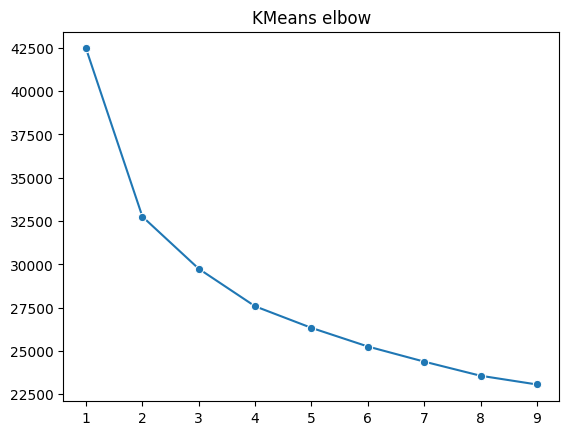

KMeans:
k=2, Silhouette Score=0.2564
k=3, Silhouette Score=0.1744
k=4, Silhouette Score=0.1817
k=5, Silhouette Score=0.1719
k=6, Silhouette Score=0.0947

Agglomerative Clustering:
k=2, Silhouette Score=0.2565
k=3, Silhouette Score=0.1637
k=4, Silhouette Score=0.1586
k=5, Silhouette Score=0.1528
k=6, Silhouette Score=0.0806

Gaussian Mixture:
k=2, Silhouette Score=0.1836
k=3, Silhouette Score=0.1832
k=4, Silhouette Score=0.0941
k=5, Silhouette Score=0.0895
k=6, Silhouette Score=0.0530


In [17]:
### K-Means 
# Elbow visualisation
elbow = {}

for k in range(1,10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_selected)
    elbow[k] = kmeans.inertia_

sns.lineplot(x=elbow.keys(), y=elbow.values(), marker='o');
plt.title("KMeans elbow")
plt.show();


# Silouette score
print(f'KMeans:')
for k in range(2,7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_selected)
    score = silhouette_score(df_selected, labels)
    print(f"k={k}, Silhouette Score={score:.4f}")


### Agglomerative Clustering
# Silouette score
print(f'\nAgglomerative Clustering:')
for k in range(2,7):
    agg_clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = agg_clustering.fit_predict(df_selected)
    score = silhouette_score(df_selected, labels)
    print(f"k={k}, Silhouette Score={score:.4f}")


### Gaussian Mixture
# Silouette score
print(f'\nGaussian Mixture:')
for k in range(2,7):
    gaussian_mix = GaussianMixture(k, covariance_type='full', random_state=42)
    labels = gaussian_mix.fit_predict(df_selected)
    score = silhouette_score(df_selected, labels)
    print(f"k={k}, Silhouette Score={score:.4f}")



MODEL           | SILHOUETTE | MAX RÓŻNICA KONWERSJI  | LICZEBNOŚCI GRUP
--------------------------------------------------------------------------------
K-Means         | 0.1817     | 20.03% (p.p.)          | [1047  556  612   20]
Agglomerative   | 0.1586     | 18.54% (p.p.)          | [ 659  532 1024   20]
GMM             | 0.0941     | 17.52% (p.p.)          | [750 818 647  20]
--------------------------------------------------------------------------------
--- ANALYSIS FOR: K-Means ---


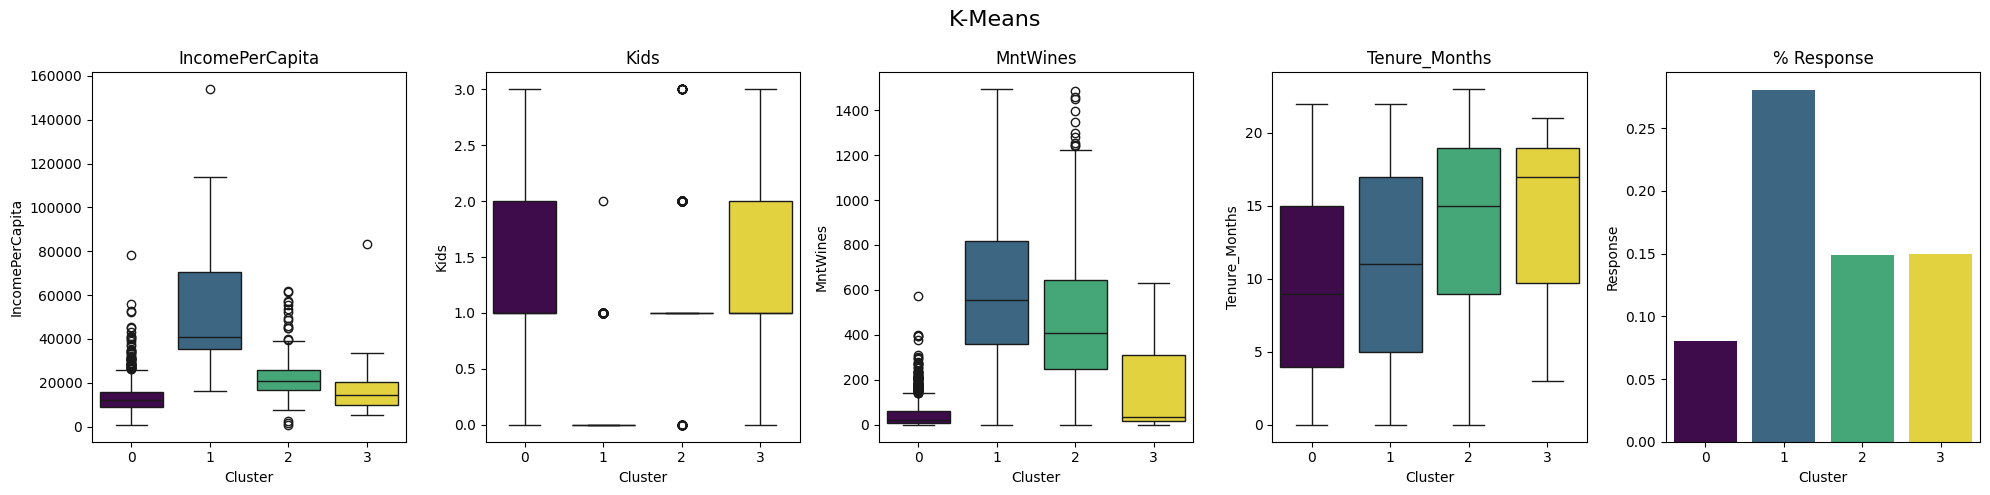

--- ANALYSIS FOR: Agglomerative ---


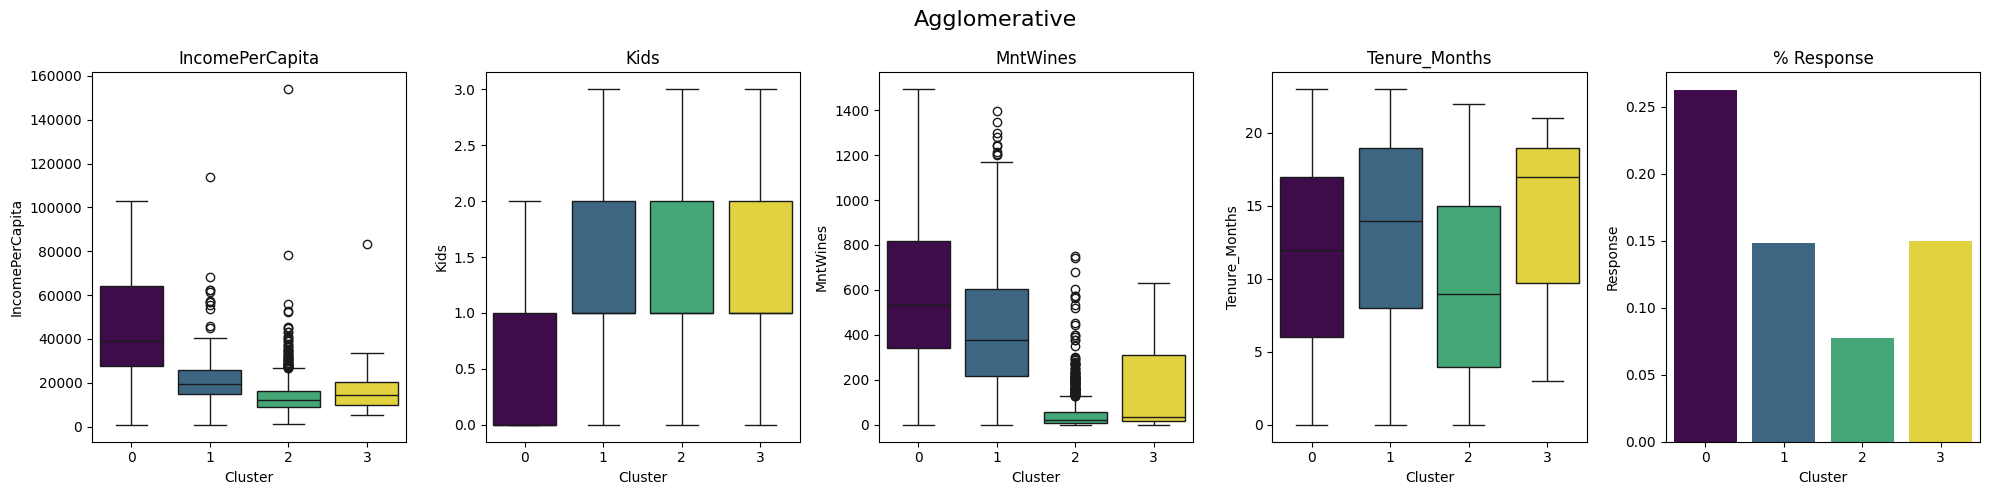

--- ANALYSIS FOR: GMM ---


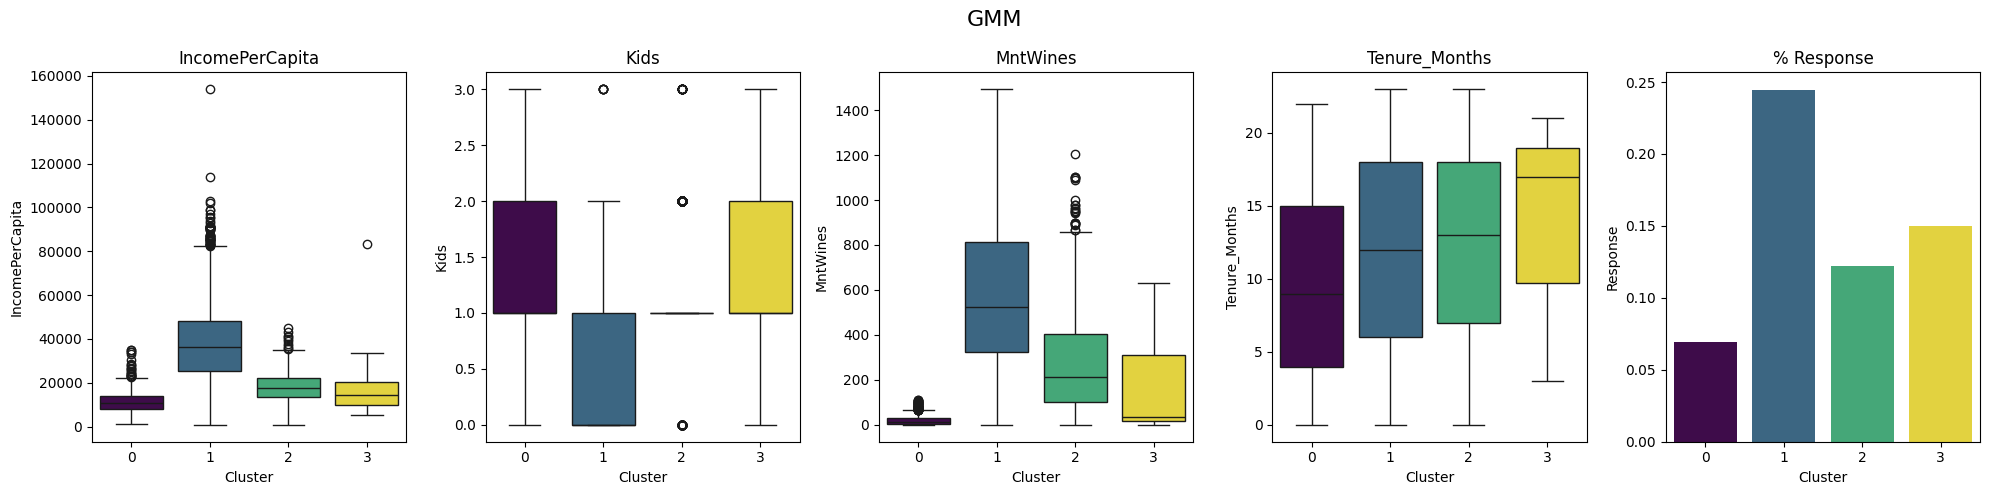

In [18]:
n=4
# Final KMeans
kmeans = KMeans(n_clusters=n, random_state=42)
df["Cluster_KMeans"] = kmeans.fit_predict(df_selected)

# Final Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=n, linkage='ward')
df['Cluster_Agglo'] = agg_clustering.fit_predict(df_selected)

# Final Agglomerative Clustering
gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
df['Cluster_GMM'] = gmm.fit_predict(df_selected)

models_labels = {
'K-Means': df['Cluster_KMeans'],
'Agglomerative': df['Cluster_Agglo'],
'GMM': df['Cluster_GMM']
}

print(f"{'MODEL':<15} | {'SILHOUETTE':<10} | {'MAX RÓŻNICA KONWERSJI':<22} | {'LICZEBNOŚCI GRUP'}")
print("-" * 80)

for name, labels in models_labels.items():
    # Silouette
    sil = silhouette_score(df_selected, labels)
    
    # Response 
    temp_df = df.copy()
    temp_df['Label'] = labels
    resp_rates = temp_df.groupby('Label')['Response'].mean()
    diff = resp_rates.max() - resp_rates.min()

    # Samples
    counts = labels.value_counts().sort_index().values
    counts_str = str(counts)

    print(f"{name:<15} | {sil:.4f}     | {diff:.2%} (p.p.){' '*9} | {counts_str}")

print("-" * 80)

# boxplots
feats_to_plot = ['IncomePerCapita', 'Kids', 'MntWines', 'Tenure_Months', 'Response']

models_dict = {
'K-Means': 'Cluster_KMeans',
'Agglomerative': 'Cluster_Agglo',
'GMM': 'Cluster_GMM'
}

for model_name, cluster_col in models_dict.items():
    print(f"--- ANALYSIS FOR: {model_name} ---")

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
    fig.suptitle(f'{model_name}', fontsize=16)

    for i, col in enumerate(feats_to_plot):
        ax = axes[i]
        
        if col == 'Response':
            # Barplot for binary vars
            sns.barplot(
                x=df[cluster_col], 
                y=df[col], 
                hue=df[cluster_col],  
                palette='viridis', 
                ax=ax, 
                errorbar=None,        
                legend=False         
            )
            ax.set_title(f'% {col}')
        
        else:
            # Boxplot for non bianry vars
            sns.boxplot(
                x=df[cluster_col], 
                y=df[col], 
                hue=df[cluster_col],  
                palette='viridis', 
                ax=ax,
                legend=False         
            )
            ax.set_title(f'{col}')
        
        ax.set_xlabel('Cluster')

    plt.tight_layout()
    plt.show()

In [19]:
print(df.groupby("Cluster_KMeans")[['MntAllProducts', 'MntWines','MntMeatProducts','MntGoldProds', 'Kids','Partner','Response','Tenure_Months','Income','IncomePerCapita']].mean())
print(df.value_counts("Cluster_KMeans"))

                MntAllProducts    MntWines  MntMeatProducts  MntGoldProds  \
Cluster_KMeans                                                              
0                   104.128940   46.803247        23.919771     15.429799   
1                  1374.253597  598.920863       457.532374     76.926259   
2                   774.315359  480.960784       149.643791     63.500000   
3                   392.000000  176.700000       117.700000     27.600000   

                    Kids   Partner  Response  Tenure_Months        Income  \
Cluster_KMeans                                                              
0               1.230181  0.654250  0.080229       9.808978  35833.192581   
1               0.163669  0.591727  0.280576      11.043165  76174.233151   
2               1.181373  0.678105  0.148693      13.647059  57787.927544   
3               1.200000  0.650000  0.150000      13.650000  45672.400000   

                IncomePerCapita  
Cluster_KMeans                   
0     

In [20]:
# Final segmentation model: K-Means
df = df.drop(['Cluster_Agglo', 'Cluster_GMM'], axis=1)
df_model = pd.get_dummies(df, columns=['Cluster_KMeans'], prefix='Cluster', drop_first=True)

# Step 7: Regression

In [21]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2235 entries, 0 to 2234
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Income               2235 non-null   float64
 1   Recency              2235 non-null   int64  
 2   MntWines             2235 non-null   int64  
 3   MntFruits            2235 non-null   int64  
 4   MntMeatProducts      2235 non-null   int64  
 5   MntFishProducts      2235 non-null   int64  
 6   MntSweetProducts     2235 non-null   int64  
 7   MntGoldProds         2235 non-null   int64  
 8   NumDealsPurchases    2235 non-null   int64  
 9   NumWebPurchases      2235 non-null   int64  
 10  NumCatalogPurchases  2235 non-null   int64  
 11  NumStorePurchases    2235 non-null   int64  
 12  NumWebVisitsMonth    2235 non-null   int64  
 13  AcceptedCmp3         2235 non-null   int64  
 14  AcceptedCmp4         2235 non-null   int64  
 15  AcceptedCmp5         2235 non-null   i

--- REPORT: Logistic Regression ---
              precision    recall  f1-score   support

           0       0.95      0.82      0.88       571
           1       0.43      0.77      0.55       100

    accuracy                           0.82       671
   macro avg       0.69      0.80      0.72       671
weighted avg       0.88      0.82      0.83       671



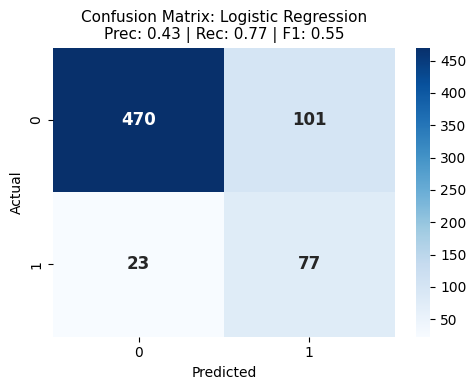


Top 15 Feature Importance (Logistic Regression):
                Feature  Importance
22      IncomePerCapita    1.195727
23        Tenure_Months    1.070021
1               Recency    1.049054
11    NumStorePurchases    0.967805
13         AcceptedCmp3    0.649853
0                Income    0.645598
15         AcceptedCmp5    0.602930
26    Education_Numeric    0.536204
16         AcceptedCmp1    0.478356
10  NumCatalogPurchases    0.430210
--- REPORT: Random Forest ---
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       571
           1       0.80      0.36      0.50       100

    accuracy                           0.89       671
   macro avg       0.85      0.67      0.72       671
weighted avg       0.88      0.89      0.87       671



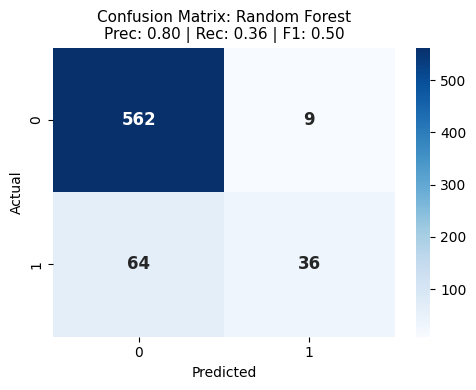

--- REPORT: XGBoost ---
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       571
           1       0.55      0.57      0.56       100

    accuracy                           0.87       671
   macro avg       0.74      0.74      0.74       671
weighted avg       0.87      0.87      0.87       671



c:\Users\Hania\Desktop\Studia\SGGW\03_Uczenie maszynowe\Projekt\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:05:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


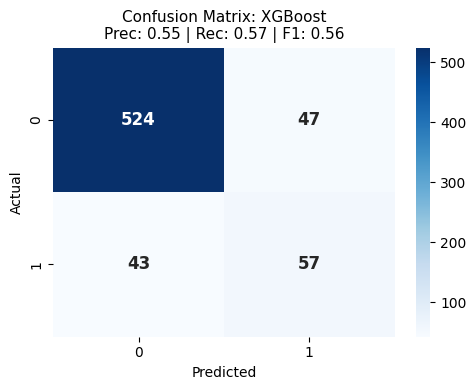

In [22]:
### Functions
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    print(f"--- REPORT: {model_name} ---")
    print(classification_report(y_test, y_pred))

    # Obliczamy metryki
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    plt.figure(figsize=(5, 4)) # Troszkę wyższy wykres, żeby zmieścić napisy
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', annot_kws={"size": 12, "weight": "bold"})

    # Tytuł z metrykami (łamanie linii \n dla czytelności)
    plt.title(f'Confusion Matrix: {model_name}\nPrec: {prec:.2f} | Rec: {rec:.2f} | F1: {f1:.2f}', fontsize=11)

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

### Train/test split
X = df_model.drop(["Response",'AcceptedCmp'],axis=1)
y = df_model['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Logistic Regression
log_reg = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

evaluate_model(log_reg, X_test_scaled, y_test, "Logistic Regression")

# Feature importance
importance_lr = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(log_reg.coef_[0])})
importance_lr = importance_lr.sort_values(by='Importance', ascending=False).head(10)
print("\nTop 15 Feature Importance (Logistic Regression):")
print(importance_lr)


### Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

evaluate_model(rf_model, X_test, y_test, "Random Forest")

### XGBoost
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
n_estimators=100,
learning_rate=0.1,
max_depth=5,
scale_pos_weight=scale_pos_weight,
random_state=42,
use_label_encoder=False,
eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

evaluate_model(xgb_model, X_test, y_test, "XGBoost")

Running experiments... (Compact View)



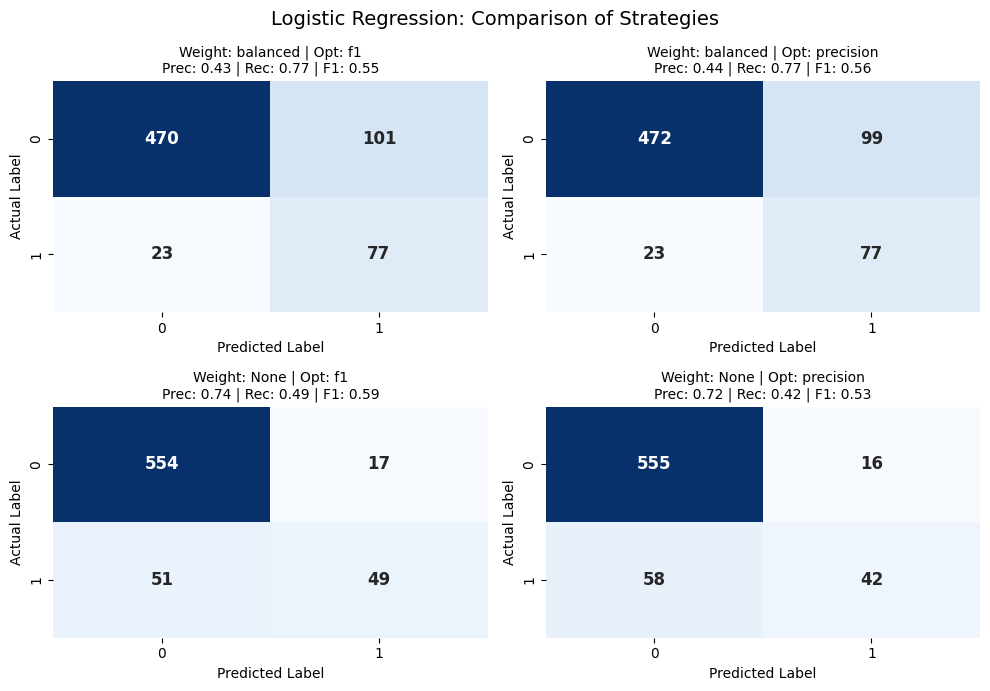

In [23]:
# ==========================================
# LOGISTIC REGRESSION: SCENARIO COMPARISON (Compact Version)
# ==========================================

# Define the scenarios
scenarios = [
('balanced', 'f1'),
('balanced', 'precision'),
(None, 'f1'),      
(None, 'precision')
]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))
fig.suptitle('Logistic Regression: Comparison of Strategies', fontsize=14, y=0.98)
axes = axes.flatten()

# Common cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Running experiments... (Compact View)\n")

for i, (weight, metric) in enumerate(scenarios):
    # 1. Setup Pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=2000, class_weight=weight, random_state=42))
    ])

    # 2. GridSearch
    grid = GridSearchCV(pipeline, {'clf__C': [0.1, 1, 10]}, cv=cv, scoring=metric, n_jobs=-1)
    grid.fit(X_train, y_train)

    # 3. Predict & Metrics
    y_pred = grid.best_estimator_.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # 4. Plot Heatmap (annot_kws powiększa cyfry w środku)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False, 
                annot_kws={"size": 12, "weight": "bold"})

    # 5. Formatting
    title_label = f"Weight: {weight} | Opt: {metric}\nPrec: {prec:.2f} | Rec: {rec:.2f} | F1: {f1:.2f}"
    axes[i].set_title(title_label, fontsize=10)
    axes[i].set_ylabel('Actual Label')
    axes[i].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()




--- Tuning RF for High Precision... ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best RF Params: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100}
Best CV Precision Score: 0.7860

--- FINAL REPORT: RANDOM FOREST (High Precision) ---
--- REPORT: RF Tuned for Precision ---
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       571
           1       0.80      0.39      0.52       100

    accuracy                           0.89       671
   macro avg       0.85      0.69      0.73       671
weighted avg       0.89      0.89      0.88       671



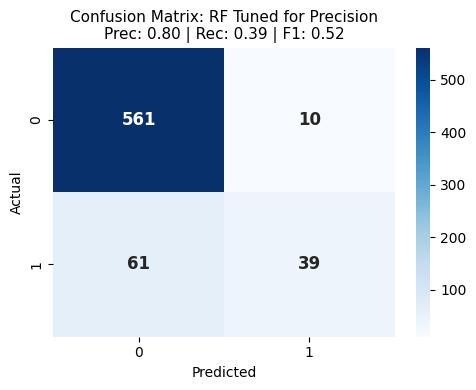

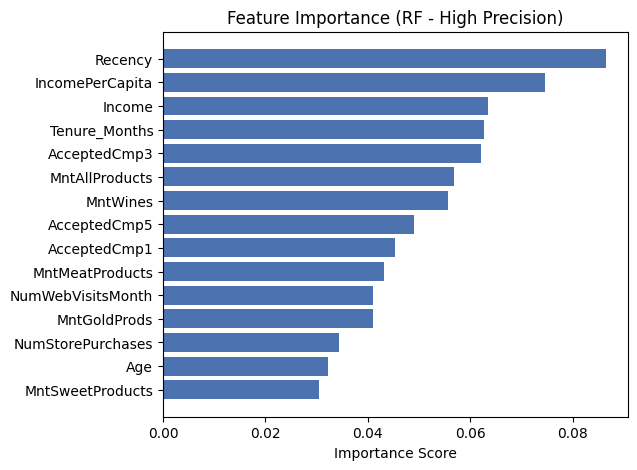

In [24]:
# ==========================================
# MODEL 2: RANDOM FOREST (Optimized for PRECISION)
# ==========================================
print("\n--- Tuning RF for High Precision... ---")

# 1. Base model WITHOUT 'balanced' weights (Standard mode)
# This makes the model more conservative -> Higher Precision
rf_precision = RandomForestClassifier(random_state=42) # class_weight removed/default

# 2. Parameter Grid
param_grid_rf = {
'n_estimators': [100, 200],
'max_depth': [5, 10, 15],
'min_samples_split': [5, 10],
'max_features': ['sqrt']
}

# 3. Optimization for PRECISION
grid_rf = GridSearchCV(
estimator=rf_precision,
param_grid=param_grid_rf,
cv=5,
scoring='precision', # We explicitly tell it: "Maximize Precision!"
n_jobs=-1,
verbose=1
)

grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
print(f"\nBest RF Params: {grid_rf.best_params_}")
print(f"Best CV Precision Score: {grid_rf.best_score_:.4f}")

print("\n--- FINAL REPORT: RANDOM FOREST (High Precision) ---")
evaluate_model(best_rf, X_test, y_test, "RF Tuned for Precision")

# Check Feature Importance again
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 15

plt.figure(figsize=(6, 5))
plt.title("Feature Importance (RF - High Precision)")
plt.barh(range(top_n), importances[indices[:top_n]][::-1], align="center", color='#4c72b0')
plt.yticks(range(top_n), [X.columns[i] for i in indices[:top_n]][::-1])
plt.xlabel("Importance Score")
plt.show()


--- Starting XGBoost Tuning... ---
Calculated scale_pos_weight: 5.68
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best XGB Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': np.float64(5.683760683760684), 'subsample': 1.0}
Best CV F1 Score: 0.6345

--- FINAL REPORT: XGBOOST ---
--- REPORT: Tuned XGBoost ---
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       571
           1       0.57      0.69      0.62       100

    accuracy                           0.88       671
   macro avg       0.76      0.80      0.78       671
weighted avg       0.89      0.88      0.88       671



c:\Users\Hania\Desktop\Studia\SGGW\03_Uczenie maszynowe\Projekt\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:05:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


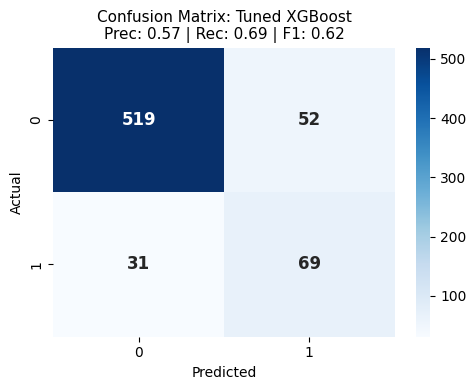

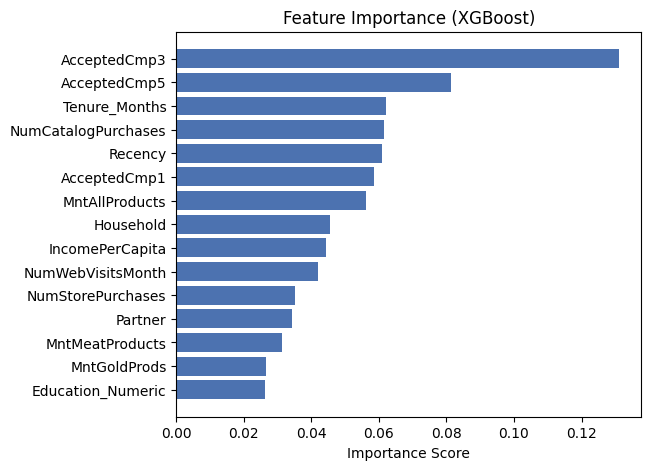

In [ ]:
# ==========================================
# MODEL 3: XGBOOST (Tuned)
# ==========================================

print("\n--- Starting XGBoost Tuning... ---")

# 1. Calculate class weight manually for XGBoost
# (Count of Negatives / Count of Positives)
# This helps the model pay attention to the minority class (Response=1)
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
print(f"Calculated scale_pos_weight: {ratio:.2f}")

# 2. Define Base Model
xgb = XGBClassifier(
random_state=42,
use_label_encoder=False,
eval_metric='logloss'
)

# 3. Define Parameter Grid
param_grid_xgb = {
'n_estimators': [100, 200],      # Number of boosting rounds
'learning_rate': [0.01, 0.1, 0.2], # Step size shrinkage (lower = more robust but slower)
'max_depth': [3, 5, 7],          # Depth of trees (lower prevents overfitting)
'subsample': [0.8, 1.0],         # Fraction of samples used for fitting trees
'scale_pos_weight': [ratio]      # Handling imbalance (remove this line for higher Precision!)
}

# 4. GridSearchCV
grid_xgb = GridSearchCV(
estimator=xgb,
param_grid=param_grid_xgb,
cv=5,
scoring='f1', # Optimizing for F1 (Balance). Change to 'precision' if needed.
n_jobs=-1,
verbose=1
)

grid_xgb.fit(X_train, y_train)

# 5. Results
best_xgb = grid_xgb.best_estimator_
print(f"\nBest XGB Params: {grid_xgb.best_params_}")
print(f"Best CV F1 Score: {grid_xgb.best_score_:.4f}")

# 6. Final Evaluation
print("\n--- FINAL REPORT: XGBOOST ---")
evaluate_model(best_xgb, X_test, y_test, "Tuned XGBoost")

# 7. FEATURE IMPORTANCE
# XGBoost usually provides the best feature selection
importances = best_xgb.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 15

plt.figure(figsize=(6,5))
plt.title("Feature Importance (XGBoost)")
plt.barh(range(top_n), importances[indices[:top_n]][::-1], align="center", color='#4c72b0')
plt.yticks(range(top_n), [X.columns[i] for i in indices[:top_n]][::-1])
plt.xlabel("Importance Score")
plt.show()